# 1. 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import sklearn
import statsmodels
import matplotlib.pyplot as plt
import os

In [2]:
# FinanceDataReader 활용한 주식 가격 데이터 수집
#!pip install -U finance-datareader

# FinanceDataReade.chart.plot()는 plotly에 의존성이 있습니다.
# 명령창에서 다음과 같이 plotly를 설치하세요
#!pip install plotly

In [3]:
# FinanceDataReader 를 fdr 별칭으로 불러오기
import FinanceDataReader as fdr
fdr.__version__

'0.9.70'

In [4]:
# 시총 상위 10개 기업
url = "https://finance.naver.com/sise/entryJongmok.naver?&page=1"
print(url)

https://finance.naver.com/sise/entryJongmok.naver?&page=1


In [5]:
# 해당 URL 로 상위 10개 종목 불러오기
df_top10 = pd.read_html(url)[0].dropna()
df_top10

,종목별,현재가,전일비,등락률,거래량,거래대금(백만),시가총액(억)
1,삼성전자,73400.0,200.0,+0.27%,20450688.0,1490685.0,4381820.0
2,SK하이닉스,156200.0,1800.0,-1.14%,3210203.0,502539.0,1137140.0
3,LG에너지솔루션,401500.0,1000.0,+0.25%,354103.0,141973.0,939510.0
4,삼성바이오로직스,774000.0,27000.0,-3.37%,135340.0,105391.0,550887.0
5,현대차,250500.0,2500.0,+1.01%,2031254.0,505993.0,529886.0
6,기아,124500.0,6800.0,+5.78%,5834473.0,718180.0,500545.0
7,셀트리온,179700.0,10300.0,-5.42%,1318318.0,240674.0,391835.0
8,POSCO홀딩스,431500.0,6000.0,-1.37%,420266.0,181940.0,364925.0
9,LG화학,453000.0,11500.0,-2.48%,444891.0,202704.0,319783.0
10,NAVER,195000.0,9000.0,-4.41%,2008144.0,395341.0,316697.0


In [6]:
# fdr를 통해 한국거래소에 속한 기업명, 코드번호 가져오기
df_krx = fdr.StockListing("KRX")[["Name", "Code"]]
df_krx.shape

(2797, 2)

In [7]:
# 시총 상위 10개 기업만 추출
df_krx[df_krx["Name"].isin(df_top10["종목별"])]

,Name,Code
0,삼성전자,005930
1,SK하이닉스,000660
2,LG에너지솔루션,373220
3,삼성바이오로직스,207940
4,현대차,005380
6,기아,000270
7,셀트리온,068270
8,POSCO홀딩스,005490
9,LG화학,051910
10,NAVER,035420


In [8]:
# 일별 시세를 수집하기 위해 종목코드가 필요하기 때문에 종목코드를 찾습니다.
# 도움말 : (shift+tab+tab)
df_10 = df_top10.merge(df_krx, left_on="종목별", right_on="Name")[["Name", "Code"]]
df_10

,Name,Code
0,삼성전자,005930
1,SK하이닉스,000660
2,LG에너지솔루션,373220
3,삼성바이오로직스,207940
4,현대차,005380
5,기아,000270
6,셀트리온,068270
7,POSCO홀딩스,005490
8,LG화학,051910
9,NAVER,035420


In [9]:
# 반복문을 사용하여 여러 종목의 종가를 수집합니다.
item_list = [fdr.DataReader(code, start="2022")["Close"] for code in df_10["Code"]]

In [10]:
# item_list 안에 시가총액 순위 별로 종가가 들어있습니다.
item_list

[Date
 2022-01-03    78600
 2022-01-04    78700
 2022-01-05    77400
 2022-01-06    76900
 2022-01-07    78300
               ...  
 2024-02-23    72900
 2024-02-26    72800
 2024-02-27    72900
 2024-02-28    73200
 2024-02-29    73400
 Name: Close, Length: 532, dtype: int64,
 Date
 2022-01-03    128500
 2022-01-04    128500
 2022-01-05    125500
 2022-01-06    125000
 2022-01-07    127000
                ...  
 2024-02-23    161400
 2024-02-26    161800
 2024-02-27    153800
 2024-02-28    158000
 2024-02-29    156200
 Name: Close, Length: 532, dtype: int64,
 Date
 2022-01-27    505000
 2022-01-28    450000
 2022-02-03    477000
 2022-02-04    504000
 2022-02-07    548000
                ...  
 2024-02-23    402000
 2024-02-26    409500
 2024-02-27    403500
 2024-02-28    400500
 2024-02-29    401500
 Name: Close, Length: 514, dtype: int64,
 Date
 2022-01-03    900338
 2022-01-04    877607
 2022-01-05    850923
 2022-01-06    828192
 2022-01-07    834122
                ...  
 2024-

In [11]:
# 수집한 리스트를 axis=1(컬럼)을 기준으로 병합(concat) 합니다.

# item_list는 현재 리스트 안에 판다스 시리즈가 있는 상태. len(item_list) = 10
df = pd.concat(item_list, axis=1)
df.columns = df_10["Name"]
df

Name,삼성전자,SK하이닉스,LG에너지솔루션,삼성바이오로직스,현대차,기아,셀트리온,POSCO홀딩스,LG화학,NAVER
Date,,,,,,,,,,
2022-01-03,78600,128500,NaN,900338,210500,82600,191210,280000,618000,376000
2022-01-04,78700,128500,NaN,877607,210000,83500,187357,286500,644000,365500
2022-01-05,77400,125500,NaN,850923,213500,85900,180614,295500,664000,355000
2022-01-06,76900,125000,NaN,828192,214000,85600,174353,304500,690000,338500
2022-01-07,78300,127000,NaN,834122,215000,86700,175798,305000,719000,338000
...,...,...,...,...,...,...,...,...,...,...
2024-02-23,72900,161400,402000.0,814000,244000,118400,180000,435500,472000,200500
2024-02-26,72800,161800,409500.0,810000,239000,114600,181500,432500,472500,199900
2024-02-27,72900,153800,403500.0,807000,238500,112600,190100,427000,466000,200000


## 활용 기업 : SK하이닉스

In [12]:
# Time Series 생성
ts = df['SK하이닉스']
ts

Date
2022-01-03    128500
2022-01-04    128500
2022-01-05    125500
2022-01-06    125000
2022-01-07    127000
               ...  
2024-02-23    161400
2024-02-26    161800
2024-02-27    153800
2024-02-28    158000
2024-02-29    156200
Name: SK하이닉스, Length: 532, dtype: int64

In [13]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: SK하이닉스, dtype: int64)

In [14]:
# 로그 변환
ts_log = np.log(ts)
ts_log

Date
2022-01-03    11.763684
2022-01-04    11.763684
2022-01-05    11.740061
2022-01-06    11.736069
2022-01-07    11.751942
                ...    
2024-02-23    11.991641
2024-02-26    11.994116
2024-02-27    11.943408
2024-02-28    11.970350
2024-02-29    11.958893
Name: SK하이닉스, Length: 532, dtype: float64

# 2. 로그 변환한 시계열에 대한 정상성 검증 및 시계열 분해

#### 이동평균, 이동표준편차를 구하고 그리는 함수

In [85]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(rotation=45)
    plt.show(block=False)

#### ADF Test로 Stationality를 검증하는 함수

In [16]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#### log 하이닉스 시계열에 적용

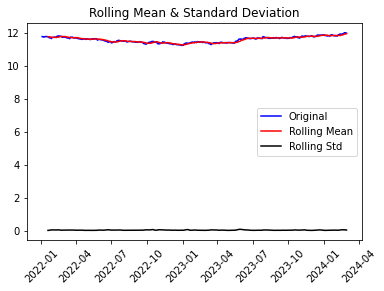

Results of Dickey-Fuller Test:
Test Statistic                  -0.702729
p-value                          0.846042
#Lags Used                       2.000000
Number of Observations Used    529.000000
Critical Value (1%)             -3.442772
Critical Value (5%)             -2.867019
Critical Value (10%)            -2.569688
dtype: float64


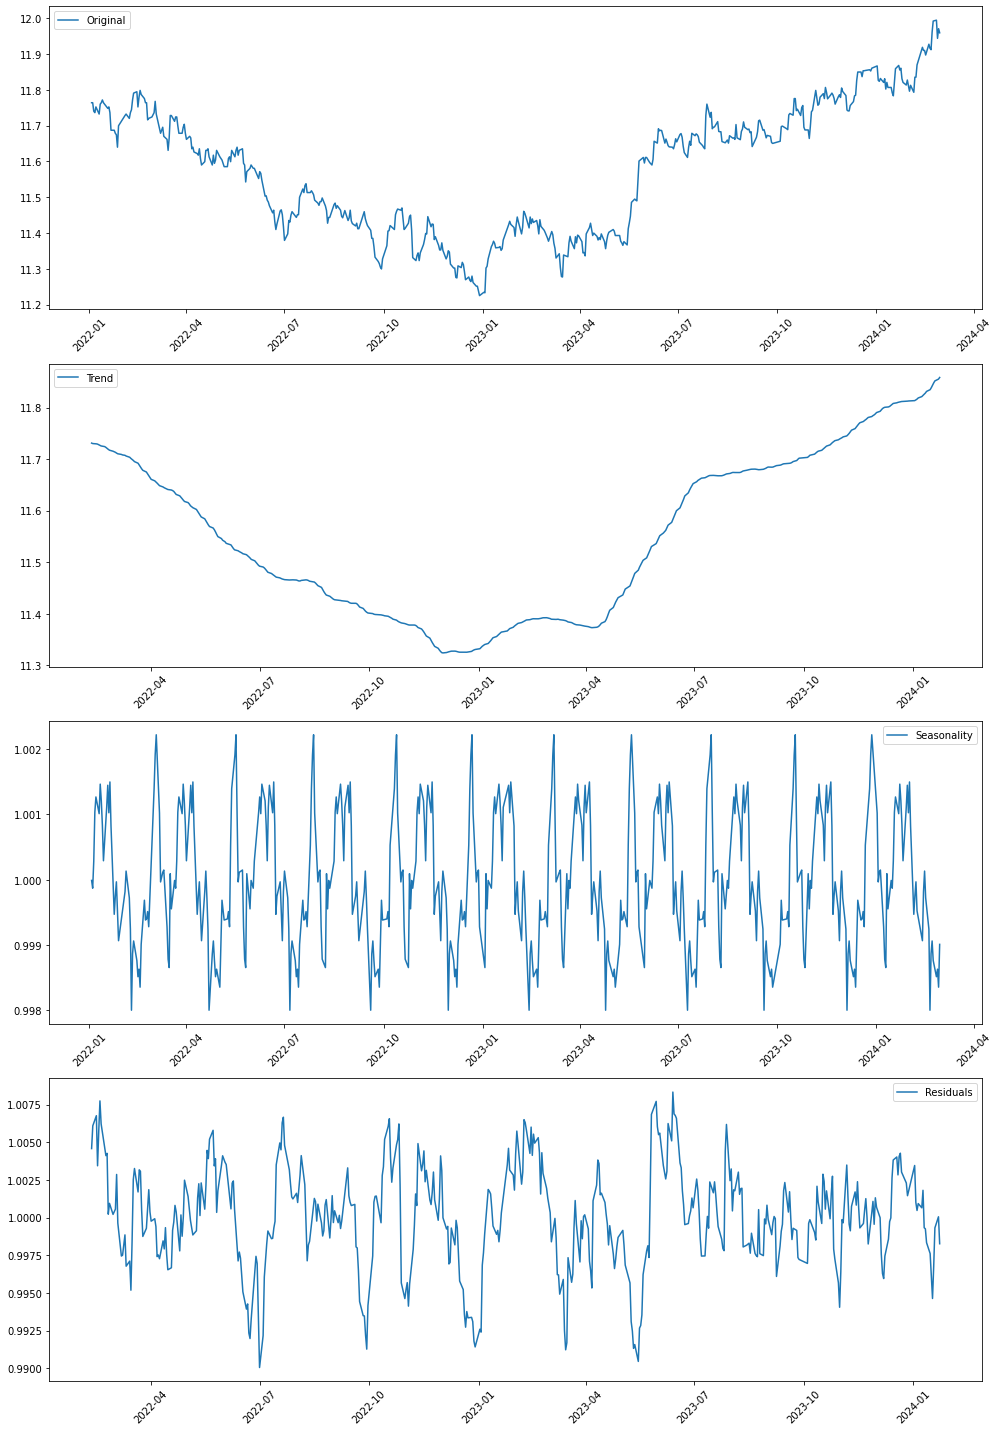

In [91]:
# 1. 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 2. 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 3. 시계열 분해 (Time Series Decomposition), 주식 가격에 대해 월봉 기준으로 period = 30 설정
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(14, 20))

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()

In [18]:
# 잔차의 Stationality를 ADF Test 로 검정
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -8.881957e+00
p-value                        1.310650e-14
#Lags Used                     9.000000e+00
Number of Observations Used    4.920000e+02
Critical Value (1%)           -3.443711e+00
Critical Value (5%)           -2.867432e+00
Critical Value (10%)          -2.569908e+00
dtype: float64


#### ㄴ p값이 0에 근사하므로, residual의 stationality를 확인

# 3. ARIMA 모수 추정을 위한 ACF, PACF 결과 확인

#### 앞서 train, test split을 진행

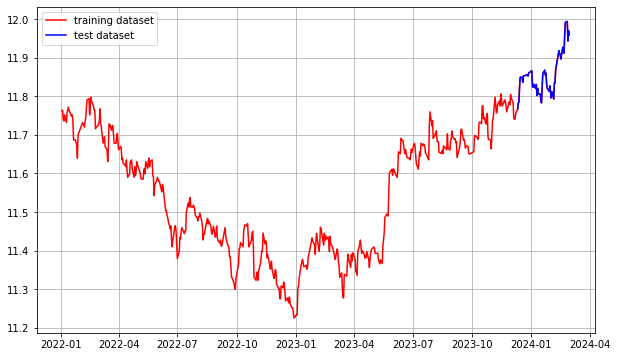

In [19]:
# 훈련, 테스트 데이터 시각화 - 앞부분 90%를 train, 최근 10%를 test로 spilt
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)

# train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### ACF, PACF 그래프 확인

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


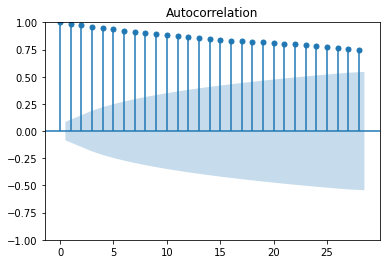

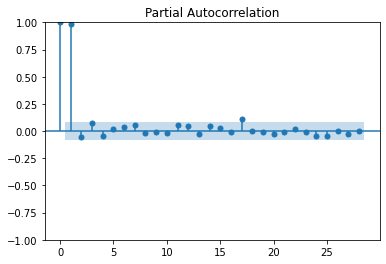

In [20]:
# ACF, PACF 그려보기 -> q, p 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.688249e+01
p-value                        1.060245e-29
#Lags Used                     1.000000e+00
Number of Observations Used    5.290000e+02
Critical Value (1%)           -3.442772e+00
Critical Value (5%)           -2.867019e+00
Critical Value (10%)          -2.569688e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.021487e+01
p-value                        5.515322e-18
#Lags Used                     1.600000e+01
Number of Observations Used    5.130000e+02
Critical Value (1%)           -3.443162e+00
Critical Value (5%)           -2.867190e+00
Critical Value (10%)          -2.569780e+00
dtype: float64


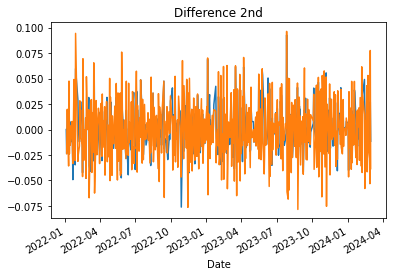

In [21]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## ㄴ AR(p), MA(q), I(d) 의 결정에 대한 판단
1. Partial Autocorrelation 그래프를 보면 lag가 1일 때 상관관계가 높고, 이후 유의수준 안에 머무르게 된다. 따라서 p는 1로 정한다.
2. Autocorrelation 그래프를 보면 lag가 30이 넘어도 상관관계가 유의수준 밖에 있는 것처럼 보인다. 시계열 분해 당시 period를 30으로 정했기 때문에 q 또한 30을 넘어가지 않도록 설정한다. q = 30.
3. 차분은 1로 적용한다.

# 4. ARIMA를 통한 예측

### 4-1. ACF, PACF에 따라 p = 1, q = 0 인 경우 (d = 1 로 고정)

In [33]:
from statsmodels.tsa.arima.model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                 SK하이닉스   No. Observations:                  478
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1154.418
Date:                Thu, 29 Feb 2024   AIC                          -2300.835
Time:                        08:38:58   BIC                          -2284.157
Sample:                             0   HQIC                         -2294.278
                                - 478                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.6043      0.090    128.265      0.000      11.427      11.782
ar.L1          0.9895      0.007    148.924      0.000       0.976       1.003
ma.L1          0.0692      0.047      1.464      0.1

#### 예측결과 시각화

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


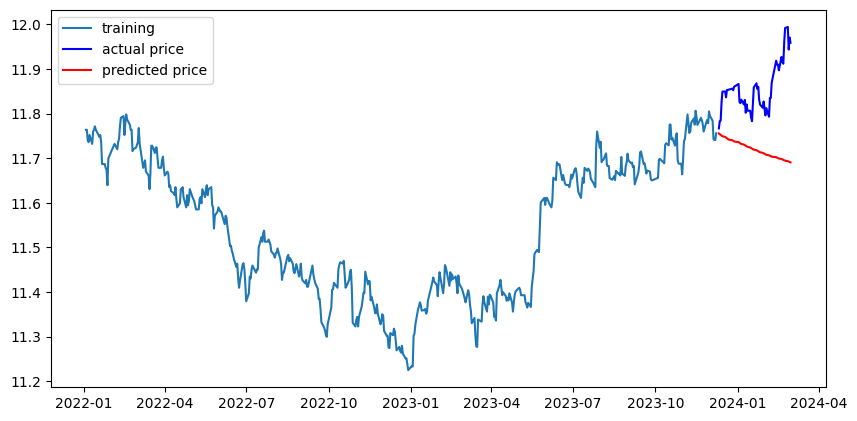

In [34]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

#### 평가지표 확인

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  412745180.9151487
MAE:  17895.263759673573
RMSE:  20316.13105183043
MAPE: 12.38%


### ㄴ 결과
1. MAPE는 15% 미만으로 나왔지만 실제 가격의 추세와 정반대 방향으로 예측값이 나오게 되었다.

### 4-2. ACF, PACF에 따라 p = 0, q = 30 인 경우

In [60]:
# Build Model
model = ARIMA(train_data, order=(0, 30, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as st

                               SARIMAX Results                                
Dep. Variable:                 SK하이닉스   No. Observations:                  478
Model:                ARIMA(0, 30, 1)   Log Likelihood                   0.000
Date:                Thu, 29 Feb 2024   AIC                              4.000
Time:                        08:41:54   BIC                             12.210
Sample:                             0   HQIC                             7.236
                                - 478                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1              -0      0.009         -0      1.000      -0.017       0.017
sigma2      1.001e+13         -0       -inf      0.000       1e+13       1e+13
Ljung-Box (L1) (Q):                    nan   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:2968: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1337: RuntimeWarning: invalid value encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:675: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


#### 예측결과 시각화

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


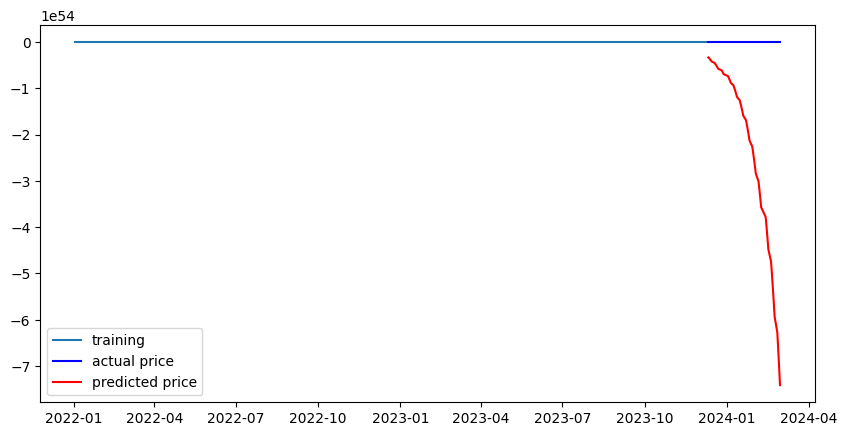

In [61]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

#### 평가지표 확인

In [62]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  19926732962.962955
MAE:  140937.037037037
RMSE:  141162.08047121917
MAPE: 100.00%


### ㄴ 결과
1. q가 높으면 위와 같은 그래프와 결과가 나오는 것을 확인했다. p, q를 적당히 조절해보며 잘 맞는 결과를 찾아보기로 한다.

### 4-3. ACF, PACF에 따라 q = 30, p = 1 인 경우

In [95]:
# Build Model
model = ARIMA(train_data, order=(1, 30, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as st

                               SARIMAX Results                                
Dep. Variable:                 SK하이닉스   No. Observations:                  478
Model:                ARIMA(1, 30, 1)   Log Likelihood                   0.000
Date:                Thu, 29 Feb 2024   AIC                              6.000
Time:                        09:30:57   BIC                             18.314
Sample:                             0   HQIC                            10.854
                                - 478                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9426   6.04e-07  -1.56e+06      0.000      -0.943      -0.943
ma.L1              -0      0.017         -0      1.000      -0.033       0.033
sigma2      5.003e+11         -0       -inf      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:2968: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1337: RuntimeWarning: invalid value encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:675: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


#### 예측결과 시각화

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


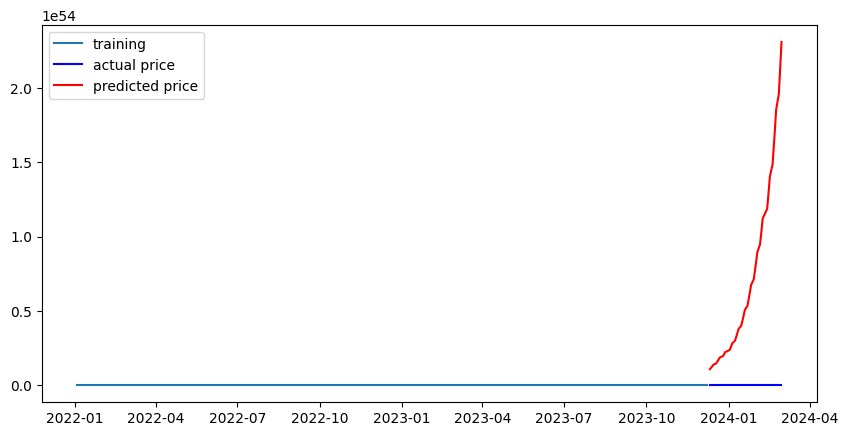

In [96]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

#### 평가지표 확인

In [97]:
# 오류발생
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

/tmp/ipykernel_71/928297452.py:2: RuntimeWarning: overflow encountered in exp
  mse = mean_squared_error(np.exp(test_data), np.exp(fc))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### ㄴ 결과
1. ACF, PACF에 따라 q, p를 조정한 경우 이상한 그래프와 함께 오류가 발생하였다.

### 4-4. p = 0, q = 2 인 경우 (여러 경우의 수를 수동으로 확인함)

In [78]:
# Build Model
model = ARIMA(train_data, order=(0, 2, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                 SK하이닉스   No. Observations:                  478
Model:                 ARIMA(0, 2, 1)   Log Likelihood                1146.273
Date:                Thu, 29 Feb 2024   AIC                          -2288.545
Time:                        08:44:43   BIC                          -2280.214
Sample:                             0   HQIC                         -2285.269
                                - 478                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9942      0.008   -131.206      0.000      -1.009      -0.979
sigma2         0.0005   2.48e-05     18.919      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   1.19   Jarque-

#### 예측결과 시각화

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


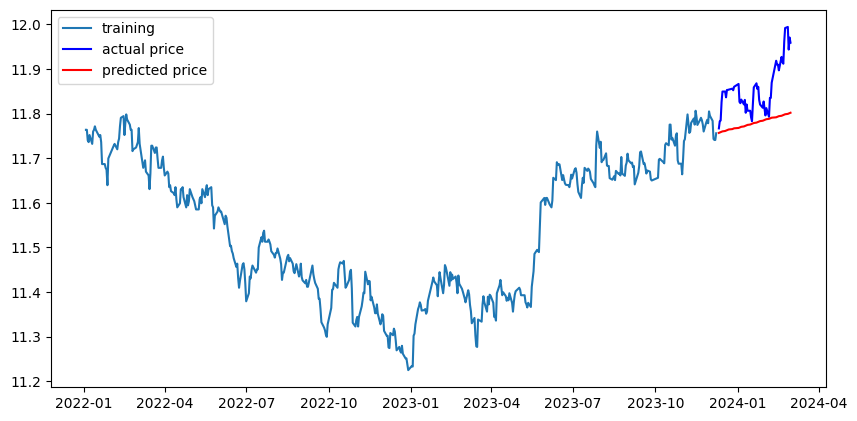

In [79]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

#### 평가지표 확인

In [80]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  156143564.06554082
MAE:  10403.807301034147
RMSE:  12495.741837343665
MAPE: 7.14%


### ㄴ 결과
1. 여러 경우의 수를 생각하여 맞춰본 결과 p = 0, q = 2, d = 1일 때 가장 양호한 결과가 나왔다.

# 회고
1. ACF, PACF에 따른 ARIMA의 모수 선택결과가 생각보다 잘 나오지 않았다.
2. 시계열 분해 당시 period를 30으로 정했는데, 사실 어떤 기준으로 정해야 할지 질문이 든다.
3. 시계열 분해로 정상적인 residual를 결과로 얻었는데, ARIMA 단계에서는 비정상적인 기존 train 데이터를 그대로 사용한 부분이 연결이 잘 안되었다.
4. 가장 낮은 MAPE는 p = 0, q = 2, d = 1 로 수동으로 구하게 되었다. 과연 이 모델이 신뢰할만한 모델인지.. 시계열 예측에 대해 좀 더 구체적인 공부의 필요성을 느꼈다.
5. 인사이트 : 가격 데이터만으로 예측한 경우 신뢰할만한 결과를 얻지 못한 것 같다. SK하이닉스의 경우, ARIMA 모델이 임의로 발생하는 외부 요인(exogenous data)으로 인한 영향을 설명하지 못했을 것이라고 생각한다.
6. 아이펠톤을 약 1달 반 남겨놓고, Coursera를 통해 트레이딩에 적용하는 머신러닝과 시계열 강의를 최근 듣기 시작했다. 남은 시간 동안 트레이딩과 시계열 분석을 공부하면서 아이펠톤을 투자 관련된 프로젝트로 수행할 수 있을지 확인하기 위해 마지막 공부 방향을 정하였다. 프로젝트를 수행할 수 있는 유의미한 성과와 아이디어가 나왔으면 좋겠다.